## ZDR calibration + differential attenuation

In [143]:
import pyart
import dask.array as da
import dask.bag as db
from dask import delayed
from distributed import Client
from dask_jobqueue import PBSCluster
from glob import glob
from datetime import datetime
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/rjackson/anaconda3/envs/cmac_env/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Use calibration technique of Bringi and Chandrashekar (2001) that estimates bias from theoretically expected ZDR in light rain. Need good light rain case. Use 2017-10-04 1600001Z



In [41]:
file_path = '/lustre/or-hydra/cades-arm/proj-shared/sgpxsaprcmacsurI5.c1/20171004/sgpxsaprcmacsurI5.c1.20171004.160022.nc'
radar = pyart.io.read(file_path)

/home/rjackson/.local/lib/python3.6/site-packages/pyart/io/cfradial.py:376: RuntimeWarning: invalid value encountered in less
  data = self.ncvar[:]
/home/rjackson/.local/lib/python3.6/site-packages/pyart/io/cfradial.py:376: RuntimeWarning: invalid value encountered in greater
  data = self.ncvar[:]


In [42]:
radar.fields.keys()

dict_keys(['total_power', 'reflectivity', 'velocity', 'spectrum_width', 'differential_reflectivity', 'specific_differential_phase', 'cross_correlation_ratio', 'normalized_coherent_power', 'differential_phase', 'xsapr_clutter', 'sounding_temperature', 'height', 'SNR', 'velocity_texture', 'gate_id', 'corrected_velocity', 'unfolded_differential_phase', 'corrected_differential_phase', 'filtered_corrected_differential_phase', 'corrected_specific_diff_phase', 'filtered_corrected_specific_diff_phase', 'specific_attenuation', 'attenuation_corrected_reflectivity', 'rain_rate_A'])

In [4]:
def zdr_adjusted(zdr0, theta):
    theta_rad = np.deg2rad(theta)
    zdr_adj = zdr0/(zdr0**0.5*np.sin(theta_rad)**2+np.cos(theta_rad)**2)**2
    return zdr_adj

In [140]:
def get_zdr_values(file):
    try:
        radar = pyart.io.read(file, delay_field_loading=True)
    except OSError:
        return np.nan
    # Check for 40 dBZ echoes above 4 km
    gate_z = radar.gate_z['data']
    ref = radar.fields['reflectivity']['data']
    snr = radar.fields['SNR']['data']
    rhohv = radar.fields['cross_correlation_ratio']['data']
    elevation = radar.elevation['data']
    zdr = radar.fields['differential_reflectivity']['data']
    gate_id = radar.fields['gate_id']['data']
    r = radar.range['data']
    which_ranges = np.where(r > 20000.0)[0]
    which_elevations = np.where(elevation > 1)[0]
    above_melting = gate_z > 4000.0
    below_melting = gate_z <= 4000.0
    
    # First test for convective sample - filter out
    num_heavy_gates_aloft = len(np.where(ref[above_melting] > 40.0)[0])
    if(num_heavy_gates_aloft > 40):
        return np.nan
    snr_rho_filter = np.logical_and(snr > 20, rhohv > 0.98)
    ref_filtered = ref[snr_rho_filter]
    len_1030 = len(np.where(np.logical_and(ref_filtered >= 10, ref_filtered <= 30))[0])
    len_30 = len(np.where(ref_filtered > 30)[0])
    if(len_30/len_1030 > 0.2):
        return np.nan
    
    zdr = np.ma.masked_where(gate_id != 1, zdr)
    ref_filtered = np.ma.masked_where(gate_id != 1, ref)

    zdr = zdr[which_elevations, :]
    zdr = zdr[:, which_ranges]
    ref_filtered = ref_filtered[which_elevations, :]
    ref_filtered = ref_filtered[:, which_ranges]
    
    del radar
    z_bins = np.linspace(19, 30.5, 7)
    mean_zdr = np.zeros(len(z_bins)-1)
    for i in range(len(z_bins)-1):
        inds = np.where(np.logical_and(ref_filtered >= z_bins[i], ref_filtered <= z_bins[i+1]))
        print(inds)
        if(len(inds[0]) > 200):
            mean_zdr[i] = np.ma.mean(zdr[inds])
        else:
            mean_zdr[i] = np.nan
    return np.nanmean(mean_zdr)    

In [6]:
get_zdr_values(file_path)

nan

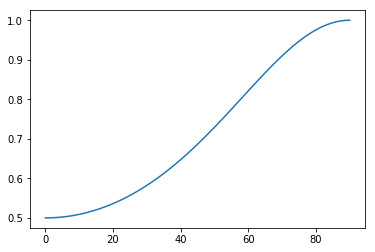

In [7]:
theta = np.linspace(0, 90, 120)
zdr05 = zdr_adjusted(0.5, theta)
plt.plot(theta, zdr05)

In [8]:
radar.fields['gate_id']

{'data': array([[0, 5, 5, ..., 1, 1, 1],
        [0, 5, 5, ..., 1, 1, 1],
        [0, 5, 5, ..., 1, 1, 1],
        ...,
        [0, 5, 5, ..., 3, 3, 3],
        [0, 5, 5, ..., 3, 3, 3],
        [0, 5, 5, ..., 3, 3, 3]]),
 'long_name': 'Classification of dominant scatterer',
 'notes': '0:multi_trip,1:rain,2:snow,3:no_scatter,4:melting,5:clutter',
 'standard_name': 'gate_id',
 'units': '',
 'valid_max': 5,
 'valid_min': 0.0}

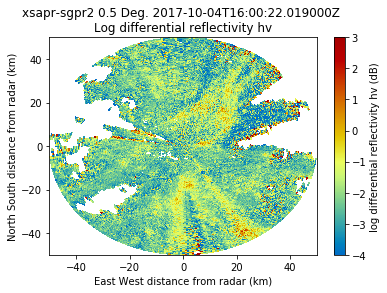

In [9]:
display = pyart.graph.RadarDisplay(radar)
gatefilter = pyart.filters.GateFilter(radar)
gatefilter.exclude_above('gate_id', 1)
gatefilter.exclude_equal('gate_id', 0)
display.plot_ppi('differential_reflectivity', 0, cmap='pyart_HomeyerRainbow', vmin=-4, vmax=3, gatefilter=gatefilter)

In [77]:
#jobqueue:
#  pbs:
#    name: dask-worker
#    cores: 36
#    memory: 270GB
#    processes: 6
#    interface: ib0
#    local-directory: $localscratch
#    queue: high_mem # Can also select batch or gpu_ssd
#    project: arm
#    walltime: 00:30:00 #Adjust this to job size
#    job-extra: ['-W group_list=cades-arm']
cluster = PBSCluster(cores=36, processes=20, threads=1, name='dask-worker', ppn=36, memory='8GB', interface='ib0',
                     local_directory='$localscratch', queue='batch',
                     walltime='2:00:00', job_extra=["-W group_list=cades-arm", "-l qos=std"])
cluster.scale(1)

/home/rjackson/anaconda3/envs/cmac_env/lib/python3.6/site-packages/distributed/bokeh/core.py:55: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn('\n' + msg)


In [78]:
client = Client(cluster)

In [75]:
client

Client Scheduler: tcp://10.23.216.82:38326 Dashboard: http://10.23.216.82:40532/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [79]:
print(cluster.job_script())

#!/bin/bash

#PBS -N dask-worker
#PBS -q batch
#PBS -l select=1:ncpus=20:mem=150GB
#PBS -l walltime=2:00:00
#PBS -W group_list=cades-arm
#PBS -l qos=std



/home/rjackson/anaconda3/envs/cmac_env/bin/dask-worker tcp://10.23.216.82:35077 --nthreads 1 --nprocs 20 --memory-limit 8GB --name dask-worker-3 --death-timeout 60 --local-directory $localscratch --interface  ib0 



In [154]:
file_list = sorted(glob('/lustre/or-hydra/cades-arm/proj-shared/sgpxsaprcmacsurI5.c1/20171004/*.nc'))
the_bag = db.from_sequence(file_list)
biases = the_bag.map(get_zdr_values).compute()

Text(0,0.5,'estimated ZDR bias')

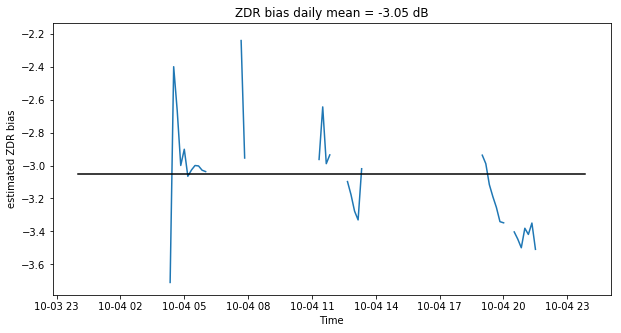

In [183]:
biases = np.array(biases)
time = [parse_time(name) for name in file_list]
#biases_mean = np.mean(rolling_window(biases, 12), -1)
plt.figure(figsize=(10,5))
plt.plot(time, biases)
plt.plot(time, np.nanmean(biases)*np.ones_like(biases), color='k')
plt.title('ZDR bias daily mean = ' + "%4.2f" % np.nanmean(biases) + ' dB')
plt.xlabel('Time')
plt.ylabel('estimated ZDR bias')

In [150]:
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

#sgpxsaprcmacsurI5.c1.20171004.160022.nc
def parse_time(fname):
    year = int(fname[-18:-14])
    month = int(fname[-14:-12])
    day = int(fname[-12:-10])
    hour = int(fname[-9:-7])
    minute = int(fname[-7:-5])
    second = int(fname[-5:-3])
    return datetime.datetime(year, month, day, hour, minute, second)

In [135]:
get_zdr_values(file_list[8])

/home/rjackson/.local/lib/python3.6/site-packages/pyart/io/cfradial.py:376: RuntimeWarning: invalid value encountered in less
  data = self.ncvar[:]
/home/rjackson/.local/lib/python3.6/site-packages/pyart/io/cfradial.py:376: RuntimeWarning: invalid value encountered in greater
  data = self.ncvar[:]


(array([ 229,  312,  670, 1054, 2289, 5678]), array([ 25,  61,  60, 246,  33,   1]))
(array([ 311,  669, 6301]), array([61, 61, 33]))
(array([ 671, 1054]), array([ 61, 245]))
(array([ 671, 2288]), array([46, 33]))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))


/home/rjackson/anaconda3/envs/cmac_env/lib/python3.6/site-packages/ipykernel/__main__.py:48: RuntimeWarning: Mean of empty slice


nan

In [170]:
# Add a 5.74 dB offset
from copy import deepcopy
radar.fields['corrected_differential_reflectivity'] = deepcopy(radar.fields['differential_reflectivity'])
radar.fields['corrected_reflectivity'] = deepcopy(radar.fields['reflectivity'])
radar.fields['corrected_reflectivity']['data'] = np.ma.masked_where(gatefilter.gate_excluded, 
                                                                   radar.fields['corrected_reflectivity']['data'])


# Get specific differential attenuation
# Need height over 0C isobar
iso0 = np.ma.mean(radar.fields['height']['data'][np.where(np.abs(radar.fields['sounding_temperature']['data']) < 0.1)])
radar.fields['height_over_iso0'] = deepcopy(radar.fields['height'])
radar.fields['height_over_iso0']['data'] -= iso0

spec_at, pia_dict, cor_z, spec_diff_at, pida_dict, cor_zdr = pyart.correct.calculate_attenuation_zphi(
    radar, temp_field='sounding_temperature', iso0_field='height_over_iso0', zdr_field='corrected_differential_reflectivity',
    pia_field='path_integrated_attenuation', refl_field='corrected_reflectivity', c=0.05, d=1, a_coef=0.313, beta=1)
cor_zdr['data'] += 3.05
radar.add_field('specific_attenuation', spec_at, replace_existing=True)
radar.add_field('path_integrated_attenuation', pia_dict, replace_existing=True)
radar.add_field('corrected_reflectivity', cor_z, replace_existing=True)
radar.add_field('specific_differential_attenuation', spec_diff_at, replace_existing=True)
radar.add_field('path_integrated_differential_attenuation', pida_dict, replace_existing=True)
radar.add_field('corrected_differential_reflectivity', cor_zdr, replace_existing=True)

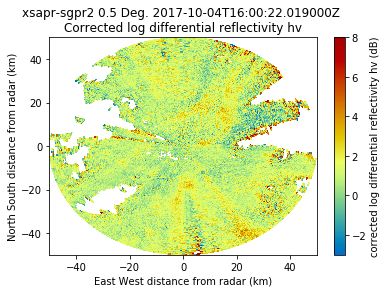

In [181]:
display = pyart.graph.RadarDisplay(radar)
gatefilter = pyart.filters.GateFilter(radar)
gatefilter.exclude_above('gate_id', 1)
gatefilter.exclude_equal('gate_id', 0)
display.plot_ppi('corrected_differential_reflectivity', 0, cmap='pyart_HomeyerRainbow', vmin=-3, vmax=8, gatefilter=gatefilter)

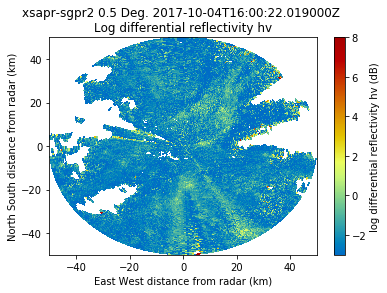

In [182]:
display = pyart.graph.RadarDisplay(radar)
gatefilter = pyart.filters.GateFilter(radar)
gatefilter.exclude_above('gate_id', 1)
gatefilter.exclude_equal('gate_id', 0)
display.plot_ppi('differential_reflectivity', 0, cmap='pyart_HomeyerRainbow', vmin=-3, vmax=8, gatefilter=gatefilter)

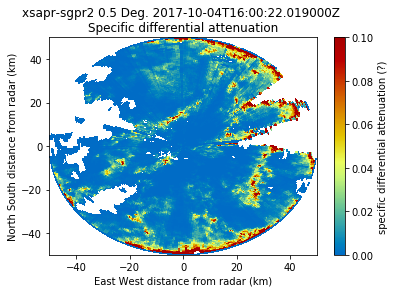

In [175]:
display = pyart.graph.RadarDisplay(radar)
gatefilter = pyart.filters.GateFilter(radar)
gatefilter.exclude_above('gate_id', 1)
gatefilter.exclude_equal('gate_id', 0)
display.plot_ppi('specific_differential_attenuation', 0, cmap='pyart_HomeyerRainbow', vmin=0, vmax=0.1, gatefilter=gatefilter)